In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/generative-dog-images/Annotation.zip
/kaggle/input/generative-dog-images/all-dogs.zip


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

### 1.Description of the problem and data 

In this challenge we need to use generative adversarial network (GAN)to create new image instance of dogs. The input data contains 20,580 images of 120 categories of breed.

### 2. Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

In [3]:
%%time
#unzip the data
import zipfile
path_to_zip_file = "../input/generative-dog-images/all-dogs.zip"
directory_to_extract_to = "./sample_data/all-dogs/"

with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

CPU times: user 6.34 s, sys: 1.8 s, total: 8.14 s
Wall time: 13.9 s


There are 20579 pictures of dogs.


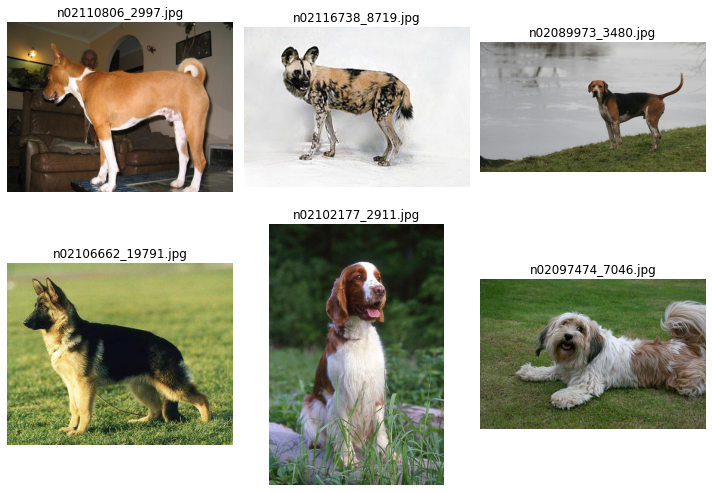

In [4]:
# show some images ./sample_data/all-dogs/all-dogs 
PATH = './sample_data/all-dogs/all-dogs/'   
images = os.listdir(PATH)
print(f'There are {len(os.listdir(PATH))} pictures of dogs.')

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10,8))

for indx, axis in enumerate(axes.flatten()):
    rnd_indx = np.random.randint(0, len(os.listdir(PATH)))
    # https://matplotlib.org/users/image_tutorial.html
    img = plt.imread(PATH + images[rnd_indx])
    imgplot = axis.imshow(img)
    axis.set_title(images[rnd_indx])
    axis.set_axis_off()
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

In [5]:
#generate data for training
# input img size 64*64*3
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler




# train_datagen = ImageDataGenerator(
#         rescale=1./255)

# BATCH_SIZE = 50
# train_batches = train_datagen.flow_from_directory('./sample_data/all-dogs/',
#         target_size=(64,64), shuffle=True, class_mode='input', batch_size=BATCH_SIZE)


### Step 3 Model Architecture 

Describe your model architecture and reasoning for why you believe that specific architecture would be suitable for this problem. 

1. Convolutional Autoencoders
    * two parts: decoder and encoder, encoder compress image into laten representation in lowe dim, in our case 64 by 64 into 8 by 8.
    * decoder is like a balance but oppose architecture as encoder. It tranform laten dim into fake image.
    * The size of laten dim will affect the result quite significant, if laten dim is 16 or 32 instead of 8, the fake image quality is much more worse.


2. Generative adversarial networks:
    * generator: input random noise(gaussian noise) output fake images. Input just like coding or laten representation of image, discriminator is a binary classifier to tell weather input image is fake or real. 
    * discriminator: same as a binary classifer, train to tell is input are fake or real image.
    * Some conventional setting in architecture are used: replace pooling layer to conv2d with larger strid, use batch norm in both G and D; output layer of generator is tanh because we want output range from -1 to 1, use leaky relu as activaion.
    

In [6]:
tf.random.set_seed(42)
np.random.seed(42)

conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([64, 64, 3], input_shape=[64, 64,3]),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(128, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    
])


conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding="SAME", activation="selu",
                                 input_shape=[8, 8, 128]),
    keras.layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding="SAME", activation="selu"),
    keras.layers.Conv2DTranspose(3, kernel_size=3, strides=2, padding="SAME", activation="sigmoid"),
    keras.layers.Reshape([64, 64, 3])
])
conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])

conv_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001))



conv_encoder.summary()
conv_decoder.summary()

2022-04-18 14:23:12.964698: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-18 14:23:13.047746: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-18 14:23:13.048482: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-18 14:23:13.049597: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 128)         0

In [7]:
train_datagen = ImageDataGenerator(rescale=1./255)

BATCH_SIZE = 128

train_batches = train_datagen.flow_from_directory('./sample_data/all-dogs/',
        target_size=(64,64), shuffle=True, class_mode='input', batch_size=BATCH_SIZE)

history = conv_ae.fit(train_batches,
        steps_per_epoch = train_batches.samples // BATCH_SIZE,
        epochs=10, batch_size=BATCH_SIZE, verbose=2)

Found 20579 images belonging to 1 classes.


2022-04-18 14:23:16.782394: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-04-18 14:23:18.792989: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


160/160 - 64s - loss: 0.5818
Epoch 2/10
160/160 - 58s - loss: 0.5593
Epoch 3/10
160/160 - 57s - loss: 0.5554
Epoch 4/10
160/160 - 58s - loss: 0.5534
Epoch 5/10
160/160 - 58s - loss: 0.5523
Epoch 6/10
160/160 - 57s - loss: 0.5512
Epoch 7/10
160/160 - 58s - loss: 0.5506
Epoch 8/10
160/160 - 58s - loss: 0.5499
Epoch 9/10
160/160 - 58s - loss: 0.5494
Epoch 10/10
160/160 - 57s - loss: 0.5490


Plot the fake images by autoencoder.

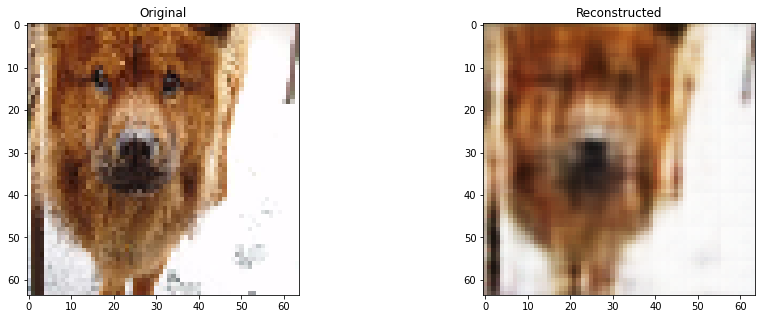

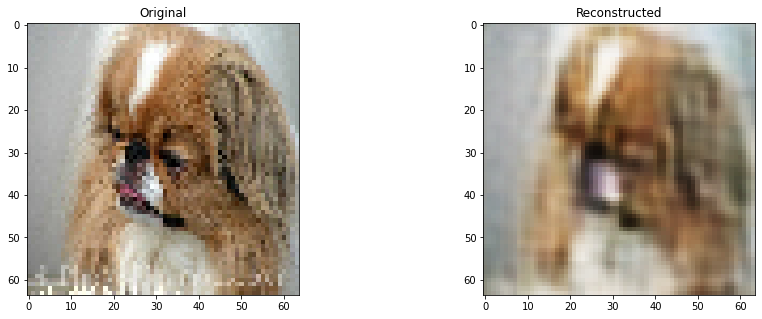

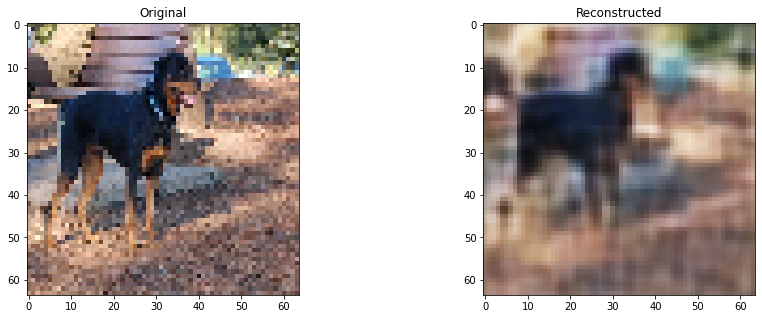

In [8]:
from PIL import Image

images = next(iter(train_batches))[0]
latentSize = (8,8,128)
for i in range(3):

    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    
    # ORIGINAL IMAGE
    orig = images[i,:,:,:].reshape((-1,64,64,3))
    img = Image.fromarray( (255*orig).astype('uint8').reshape((64,64,3)))
    plt.title('Original')
    plt.imshow(img)

    # LATENT IMAGE
    latent_img = conv_encoder.predict(orig)
    mx = np.max( latent_img[0] )
    mn = np.min( latent_img[0] )
    latent_flat = ((latent_img[0] - mn) * 255/(mx - mn)).flatten(order='F')
    img = Image.fromarray( latent_flat[:2025].astype('uint8').reshape((45,45)), mode='L') 


    # RECONSTRUCTED IMAGE
    decoded_imgs = conv_decoder.predict(latent_img[0].reshape((-1,latentSize[0],latentSize[1],latentSize[2])))
    img = Image.fromarray( (255*decoded_imgs[0]).astype('uint8').reshape((64,64,3)))
    plt.subplot(1,2,2)
    plt.title('Reconstructed')
    plt.imshow(img)
    
    plt.show()

 ### Deep Convolutional GAN

In [9]:
def plot_multiple_images(images, n_cols=None):
    img = images[:4].numpy()
    plt.figure(figsize=(10,10))
    #plt.subplot(1,2,1)
    #img = Image.fromarray( (255*orig).astype('uint8').reshape((64,64,3)))
    for i in range(1,img.shape[0]):
        plt.subplot(3,3,i)
        plt.imshow(img[i])
        #plt.axis("off")
    
#     n_cols = n_cols or len(images)
#     n_rows = 10 #(len(images) - 1) // n_cols + 1
#     if images.shape[-1] == 1:
#         images = np.squeeze(images, axis=-1)
#     plt.figure(figsize=(15, 15))
#     for index, image in enumerate(images):
#         plt.subplot(n_rows, n_cols, index+1)
#         plt.imshow(image)
#         plt.axis("off") 

In [10]:
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 1000  #laten dim  8 by 8

generator = keras.models.Sequential([
    keras.layers.Dense(8 * 8 * 128, input_shape=[codings_size]),  #[8,8,128]
    keras.layers.Reshape([8, 8, 128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="SAME",
                                 activation=keras.layers.LeakyReLU(alpha=0.2)),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(128, kernel_size=5, strides=2, padding="SAME",
                                 activation=keras.layers.LeakyReLU(alpha=0.2)),
    keras.layers.BatchNormalization(),
    #out put layer 3 channels
    keras.layers.Conv2DTranspose(3, kernel_size=5, strides=2, padding="SAME",
                                 activation="tanh"),
])

discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2),
                        input_shape=[64, 64, 3]),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(256, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation="sigmoid")
])

generator.summary()
discriminator.summary()
gan = keras.models.Sequential([generator, discriminator])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8192)              8200192   
_________________________________________________________________
reshape_2 (Reshape)          (None, 8, 8, 128)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 8, 8, 128)         512       
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 16, 16, 64)        204864    
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 64)        256       
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 32, 32, 128)       204928    
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 128)      

In [11]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")  
# optimizer="rmsprop", keras.optimizers.Adam(learning_rate=0.003)
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop") 

In [12]:
# noise = tf.random.normal(shape=[64, 100])
# generated_images = generator(noise)
# plot_multiple_images(generated_images, 8) 

In [13]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=10):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))     
        batches = 0
        for X_batch in dataset:
            # phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch[0]], axis=0)
            
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * X_batch[0].shape[0])
            #print(y1)
            #y1 = y1 + 0.005 * tf.random.uniform((y1.numpy().shape[0],1))  # some noise to labels
            #print(y1)
            
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            
            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
            
            #count batch to stop
            batches += 1
            if batches >=  20579 // batch_size: #about 1 data flow
                break
        
        plot_multiple_images(generated_images, 8)                     
        plt.show()                                                    

Found 20579 images belonging to 1 classes.
Epoch 1/20


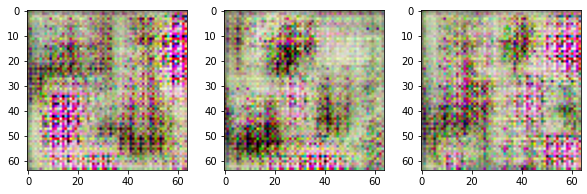

Epoch 2/20


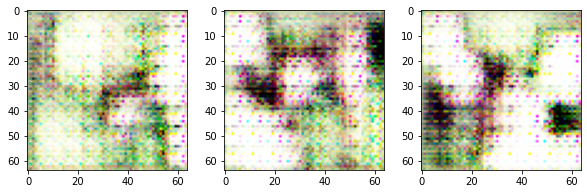

Epoch 3/20


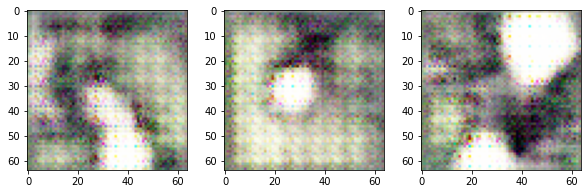

Epoch 4/20


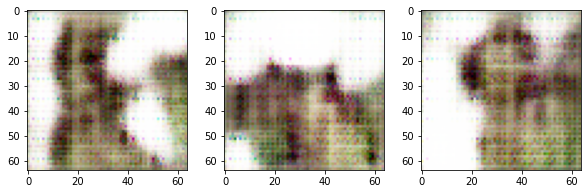

Epoch 5/20


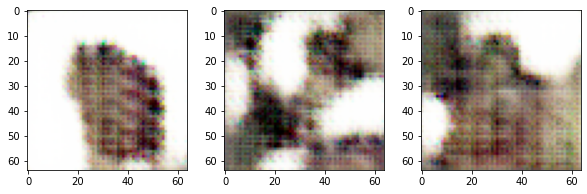

Epoch 6/20


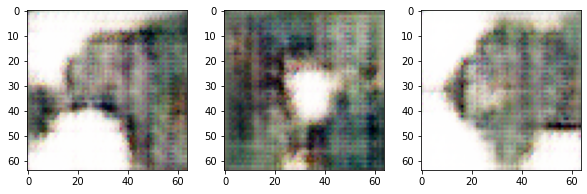

Epoch 7/20


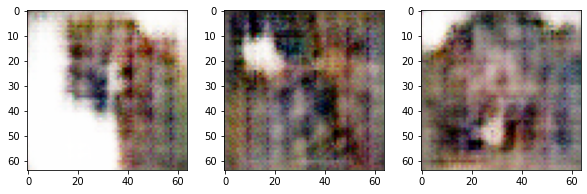

Epoch 8/20


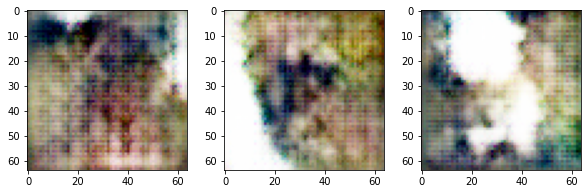

Epoch 9/20


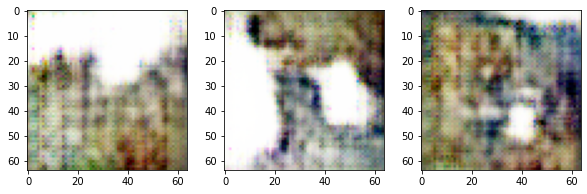

Epoch 10/20


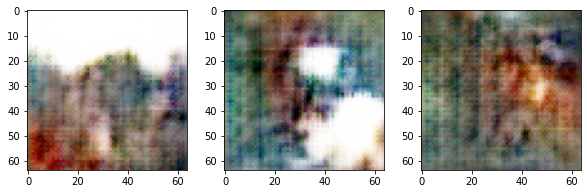

Epoch 11/20


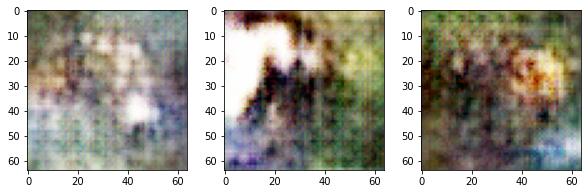

Epoch 12/20


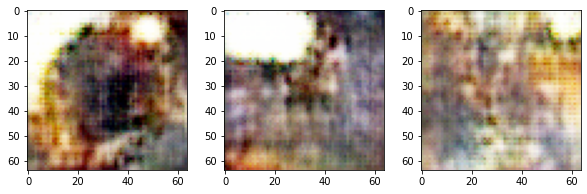

Epoch 13/20


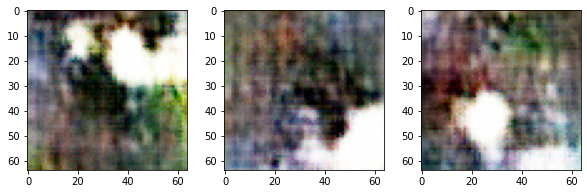

Epoch 14/20


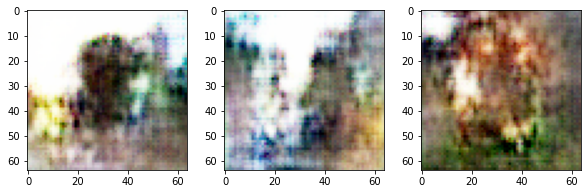

Epoch 15/20


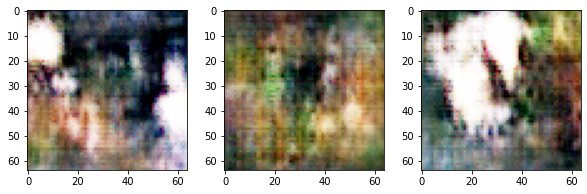

Epoch 16/20


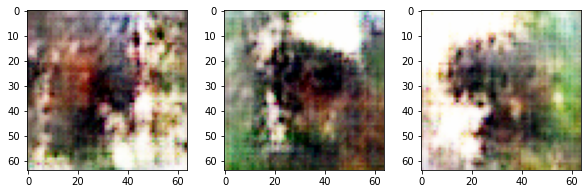

Epoch 17/20


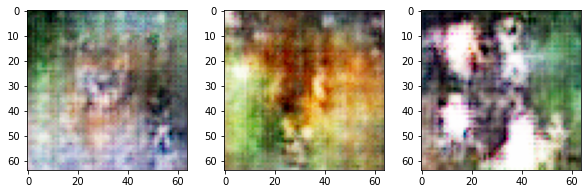

Epoch 18/20


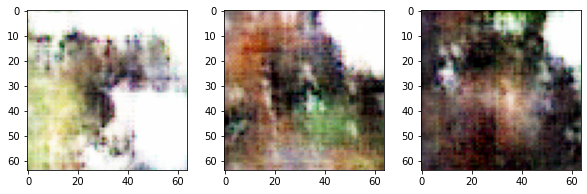

Epoch 19/20


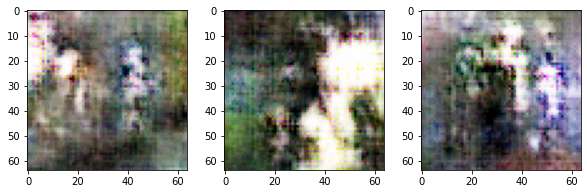

Epoch 20/20


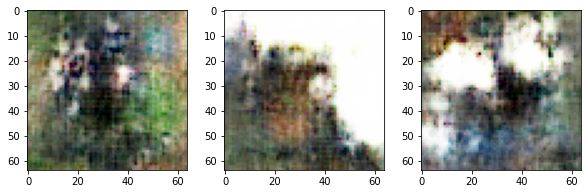

In [14]:
CODING_SIZE = 1000
n_epochs = 20
BATCH_SIZE = 128
# train_batches = train_datagen.flow_from_directory('./sample_data/all-dogs/',
#         target_size=(64,64), shuffle=True, class_mode='input', batch_size=BATCH_SIZE)

datagen = ImageDataGenerator(rescale=1./255)
train_batches = keras.preprocessing.image.DirectoryIterator('./sample_data/all-dogs/',
                                    image_data_generator=datagen,
                                    class_mode='input',target_size=(64,64), batch_size=BATCH_SIZE)

# call tain func
train_gan(gan, train_batches, BATCH_SIZE, CODING_SIZE,n_epochs)

### Step 4 Results and Analysis 

Run hyperparameter tuning, try different architectures for comparison, apply techniques to improve training or performance, and discuss what helped.

1. Autoencoder: trainin process is fast, about 60s per epoch, generate fake image a little fuzzy.

2. GAN Training need much more time in GAN model, even in this basic gan model with 3 layers in D and 3 layers in G. But, the image sometime is better than autoencoder with complex gan.
    * Some difficult when training gan: the generator will become less diverse and generate image  focuse on few classes, and don't know how to generate new images in other class.
    
3. Quality of result: can compare MiFID metric, (https://www.kaggle.com/code/wendykan/demo-mifid-metric-for-dog-image-generation-comp/notebook). Or simply display the fake image and visual by eyes.

#### example output 1 form autoencoder:
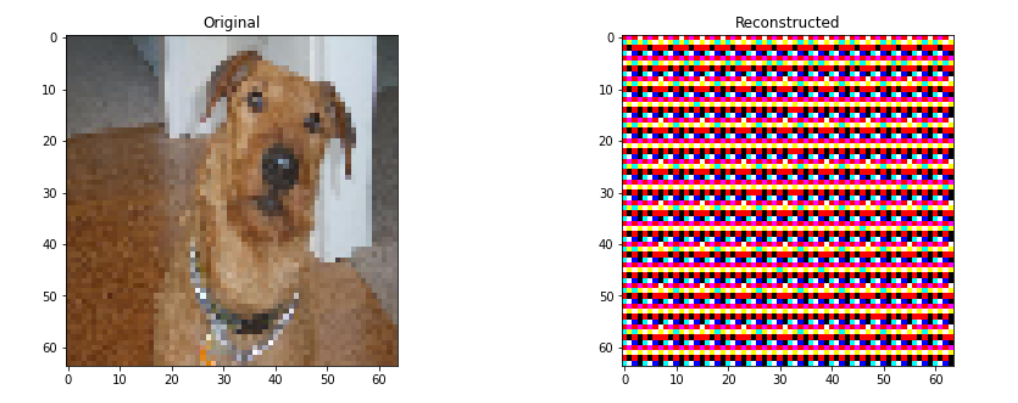



### example 2:
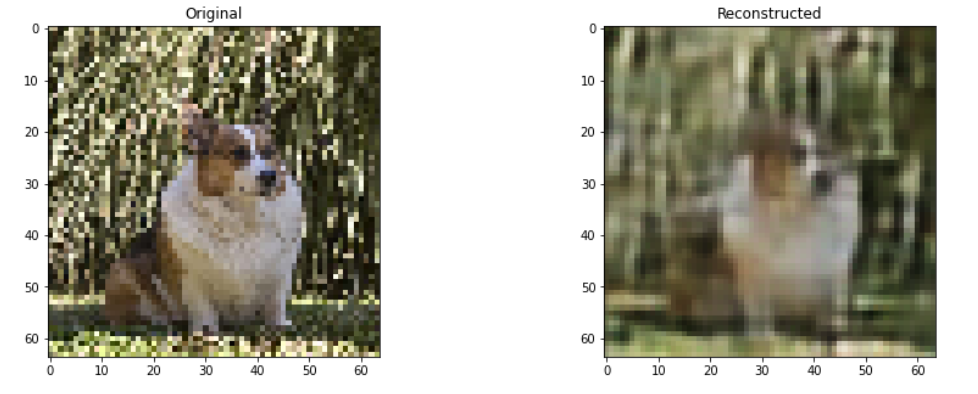

###  Step 5 Conclusion

Discuss and interpret results as well as learnings and takeaways. What did and did not help improve the performance of your models? What improvements could you try in the future?

* The result of two setting is showed above, training gan is sentative to hyperparameters such as learning rate, laten dim size, cov layer filter number etc. 

* Gan model took long time to train, so far we built model like CNN, RNN for image or text data, but this gan takes longer time to run, so key takeaway is optimize a better structure, use better hardware, or use more time.

Reference: 

https://www.kaggle.com/code/jesucristo/gan-introduction/notebook

https://www.kaggle.com/code/wendykan/gan-dogs-starter/notebook

https://www.kaggle.com/code/roydatascience/introduction-to-generative-adversarial-networks/notebook

https://www.kaggle.com/code/cdeotte/dog-autoencoder/notebook